In [58]:
# Date: 22-5-2017

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [2]:
# note:
# Because of the 十一黃金周. sth is strange with (2,0,'tot') and others vol from 1 Oct 00:00 to 7 Oct 23:59

df_merged_volume = pd.read_csv("../data/preprocessed_input_interpolate_20min.csv")

In [3]:
# change "Date" to datetime object
df_merged_volume['date'] = pd.to_datetime(df_merged_volume['date'])

# construct "time of day"
df_merged_volume['timeofday'] = df_merged_volume.date.apply( lambda d : d.hour+d.minute/60.)

In [4]:
df_merged_volume.head(10)

,"(1, 0, 'cargocar')","(1, 0, 'etc')","(1, 0, 'motorcycle')","(1, 0, 'privatecar')","(1, 0, 'tot')","(1, 0, 'unknowncar')","(1, 1, 'cargocar')","(1, 1, 'etc')","(1, 1, 'motorcycle')","(1, 1, 'privatecar')",...,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,0,1.0,0,0,14.0,14.0,38.0,25.0,89.0,12.0,...,1013.200000,1018.200000,341.000000,3.5,21.100000,68.000000,0.0,1,0,0.000000
1,0,0.0,0,0,13.0,13.0,24.0,11.0,41.0,15.0,...,1013.233333,1018.233333,342.444444,3.4,21.411111,66.888889,0.0,1,0,0.333333
2,0,1.0,0,0,7.0,7.0,10.0,7.0,22.0,5.0,...,1013.266667,1018.266667,343.888889,3.3,21.722222,65.777778,0.0,1,0,0.666667
3,0,2.0,0,0,6.0,6.0,3.0,0.0,3.0,0.0,...,1013.300000,1018.300000,345.333333,3.2,22.033333,64.666667,0.0,1,0,1.000000
4,0,1.0,0,0,5.0,5.0,5.0,0.0,3.0,0.0,...,1013.333333,1018.333333,346.777778,3.1,22.344444,63.555556,0.0,1,0,1.333333
5,0,1.0,0,0,5.0,5.0,3.0,1.0,8.0,0.0,...,1013.366667,1018.366667,348.222222,3.0,22.655556,62.444444,0.0,1,0,1.666667
6,0,0.0,0,0,6.0,6.0,6.0,1.0,2.0,0.0,...,1013.400000,1018.400000,349.666667,2.9,22.966667,61.333333,0.0,1,0,2.000000
7,0,2.0,0,0,9.0,9.0,8.0,1.0,4.0,0.0,...,1013.433333,1018.433333,351.111111,2.8,23.277778,60.222222,0.0,1,0,2.333333
8,0,0.0,0,0,7.0,7.0,4.0,1.0,4.0,0.0,...,1013.466667,1018.466667,352.555556,2.7,23.588889,59.111111,0.0,1,0,2.666667
9,0,0.0,0,0,10.0,10.0,2.0,0.0,0.0,0.0,...,1013.500000,1018.500000,354.000000,2.6,23.900000,58.000000,0.0,1,0,3.000000


In [93]:
# Make the dataset stationary

df_merged_volume_copy = df_merged_volume.copy()

for i in range(1, len(df_merged_volume_copy)):
    df_merged_volume_copy.loc[i, df_merged_volume_copy.columns[0:36]] = df_merged_volume.loc[i, df_merged_volume.columns[0:36]] - df_merged_volume.loc[i-1, df_merged_volume.columns[0:36]]

In [94]:
df_merged_volume_copy

,"(1, 0, 'cargocar')","(1, 0, 'etc')","(1, 0, 'motorcycle')","(1, 0, 'privatecar')","(1, 0, 'tot')","(1, 0, 'unknowncar')","(1, 1, 'cargocar')","(1, 1, 'etc')","(1, 1, 'motorcycle')","(1, 1, 'privatecar')",...,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,0,1.0,0,0,14.0,14.0,38.0,25.0,89.0,12.0,...,1013.200000,1018.200000,341.000000,3.500000,21.100000,68.000000,0.0,1,0,0.000000
1,0,-1.0,0,0,-1.0,-1.0,-14.0,-14.0,-48.0,3.0,...,1013.233333,1018.233333,342.444444,3.400000,21.411111,66.888889,0.0,1,0,0.333333
2,0,1.0,0,0,-6.0,-6.0,-14.0,-4.0,-19.0,-10.0,...,1013.266667,1018.266667,343.888889,3.300000,21.722222,65.777778,0.0,1,0,0.666667
3,0,1.0,0,0,-1.0,-1.0,-7.0,-7.0,-19.0,-5.0,...,1013.300000,1018.300000,345.333333,3.200000,22.033333,64.666667,0.0,1,0,1.000000
4,0,-1.0,0,0,-1.0,-1.0,2.0,0.0,0.0,0.0,...,1013.333333,1018.333333,346.777778,3.100000,22.344444,63.555556,0.0,1,0,1.333333
5,0,0.0,0,0,0.0,0.0,-2.0,1.0,5.0,0.0,...,1013.366667,1018.366667,348.222222,3.000000,22.655556,62.444444,0.0,1,0,1.666667
6,0,-1.0,0,0,1.0,1.0,3.0,0.0,-6.0,0.0,...,1013.400000,1018.400000,349.666667,2.900000,22.966667,61.333333,0.0,1,0,2.000000
7,0,2.0,0,0,3.0,3.0,2.0,0.0,2.0,0.0,...,1013.433333,1018.433333,351.111111,2.800000,23.277778,60.222222,0.0,1,0,2.333333
8,0,-2.0,0,0,-2.0,-2.0,-4.0,0.0,0.0,0.0,...,1013.466667,1018.466667,352.555556,2.700000,23.588889,59.111111,0.0,1,0,2.666667
9,0,0.0,0,0,3.0,3.0,-2.0,-1.0,-4.0,0.0,...,1013.500000,1018.500000,354.000000,2.600000,23.900000,58.000000,0.0,1,0,3.000000


In [46]:
for idx, i in enumerate(df_merged_volume.columns):
    print(idx, i)

0 (1, 0, 'cargocar')
1 (1, 0, 'etc')
2 (1, 0, 'motorcycle')
3 (1, 0, 'privatecar')
4 (1, 0, 'tot')
5 (1, 0, 'unknowncar')
6 (1, 1, 'cargocar')
7 (1, 1, 'etc')
8 (1, 1, 'motorcycle')
9 (1, 1, 'privatecar')
10 (1, 1, 'tot')
11 (1, 1, 'unknowncar')
12 (2, 0, 'cargocar')
13 (2, 0, 'etc')
14 (2, 0, 'motorcycle')
15 (2, 0, 'privatecar')
16 (2, 0, 'tot')
17 (2, 0, 'unknowncar')
18 (3, 0, 'cargocar')
19 (3, 0, 'etc')
20 (3, 0, 'motorcycle')
21 (3, 0, 'privatecar')
22 (3, 0, 'tot')
23 (3, 0, 'unknowncar')
24 (3, 1, 'cargocar')
25 (3, 1, 'etc')
26 (3, 1, 'motorcycle')
27 (3, 1, 'privatecar')
28 (3, 1, 'tot')
29 (3, 1, 'unknowncar')
30 ('A', 2)
31 ('A', 3)
32 ('B', 1)
33 ('B', 3)
34 ('C', 1)
35 ('C', 3)
36 date
37 hour
38 pressure
39 sea_pressure
40 wind_direction
41 wind_speed
42 temperature
43 rel_humidity
44 precipitation
45 dayofweek
46 is_holiday
47 timeofday


In [ ]:
''' OLD Function for converting it as stationary data'''

# # create a differenced series for Volumn and traffic time [modified from http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/]
# def difference(dataset, interval=1):
#     diff_array = np.ndarray(np.shape(dataset))
#     for i in range(interval, len(dataset)):
#         diff_array[i][0:2] = dataset[i][0:2] - dataset[i - interval][0:2]  # only select index 0 & 1
#     return diff_array[1:]  # eliminate the first row (all zeros)

# # invert differenced value
# def inverse_difference(history, y_hat, interval=1):
#     return y_hat + history[-interval]

In [95]:
# select the time for training: 6:20-10:00 (5 + 6 timestamp) and 15:20-19:00 (5 + 6 timestamp)

sel_rows = df_merged_volume_copy[ ((df_merged_volume_copy.timeofday>= 6.3) & (df_merged_volume_copy.timeofday<10)) |
                            ((df_merged_volume_copy.timeofday>=15.3) & (df_merged_volume_copy.timeofday<19))]

In [96]:
# select using columns

using_cols = [
#                 "(1, 0, 'cargocar')",
#                 "(1, 0, 'etc')",
#                 "(1, 0, 'motorcycle')",
#                 "(1, 0, 'privatecar')",
#                 "(1, 0, 'tot')",
#                 "(1, 0, 'unknowncar')",
#                 "(1, 1, 'cargocar')",
#                 "(1, 1, 'etc')",
#                 "(1, 1, 'motorcycle')",
#                 "(1, 1, 'privatecar')",
#                 "(1, 1, 'tot')",
#                 "(1, 1, 'unknowncar')",
                "(2, 0, 'cargocar')",
                "(2, 0, 'etc')",
                "(2, 0, 'motorcycle')",
                "(2, 0, 'privatecar')",
                "(2, 0, 'tot')",
#                 "(2, 0, 'unknowncar')",
#                 "(3, 0, 'cargocar')",
#                 "(3, 0, 'etc')",
#                 "(3, 0, 'motorcycle')",
#                 "(3, 0, 'privatecar')",
#                 "(3, 0, 'tot')",
#                 "(3, 0, 'unknowncar')",
#                 "(3, 1, 'cargocar')",
#                 "(3, 1, 'etc')",
#                 "(3, 1, 'motorcycle')",
#                 "(3, 1, 'privatecar')",
#                 "(3, 1, 'tot')",
#                 "(3, 1, 'unknowncar')",
                "('A', 2)",
#                 "('A', 3)",
#                 "('B', 1)",
#                 "('B', 3)",
#                 "('C', 1)",
#                 "('C', 3)",
                'date',
                'hour',
                'pressure',
                'sea_pressure',
                'wind_direction',
                'wind_speed',
                'temperature',
                'rel_humidity',
                'precipitation',
                'dayofweek',
                'is_holiday',
                'timeofday'
              ]

sel_rows = sel_rows[using_cols]

In [98]:
sel_rows.head(20)

,"(2, 0, 'cargocar')","(2, 0, 'etc')","(2, 0, 'motorcycle')","(2, 0, 'privatecar')","(2, 0, 'tot')","('A', 2)",date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
19,0,4.0,0,0,-2.0,22.7075,2016-09-20 06:20:00,6,1012.244444,1017.244444,7.444444,4.588889,26.733333,42.888889,0.0,1,0,6.333333
20,0,6.0,0,0,23.0,-52.1000,2016-09-20 06:40:00,6,1012.288889,1017.288889,7.888889,4.577778,26.566667,42.777778,0.0,1,0,6.666667
21,0,15.0,0,0,25.0,30.0500,2016-09-20 07:00:00,7,1012.333333,1017.333333,8.333333,4.566667,26.400000,42.666667,0.0,1,0,7.000000
22,0,6.0,0,0,7.0,-15.4800,2016-09-20 07:20:00,7,1012.377778,1017.377778,8.777778,4.555556,26.233333,42.555556,0.0,1,0,7.333333
23,0,2.0,0,0,7.0,0.6650,2016-09-20 07:40:00,7,1012.422222,1017.422222,9.222222,4.544444,26.066667,42.444444,0.0,1,0,7.666667
24,0,-3.0,0,0,19.0,3.3950,2016-09-20 08:00:00,8,1012.466667,1017.466667,9.666667,4.533333,25.900000,42.333333,0.0,1,0,8.000000
25,0,6.0,0,0,-1.0,-10.2000,2016-09-20 08:20:00,8,1012.511111,1017.511111,10.111111,4.522222,25.733333,42.222222,0.0,1,0,8.333333
26,0,-6.0,0,0,1.0,32.7900,2016-09-20 08:40:00,8,1012.555556,1017.555556,10.555556,4.511111,25.566667,42.111111,0.0,1,0,8.666667
27,0,-7.0,0,0,-7.0,-14.6200,2016-09-20 09:00:00,9,1012.600000,1017.600000,11.000000,4.500000,25.400000,42.000000,0.0,1,0,9.000000
28,0,-1.0,0,0,-6.0,-7.6300,2016-09-20 09:20:00,9,1012.722222,1017.722222,12.555556,4.188889,25.033333,43.222222,0.0,1,0,9.333333


In [ ]:
sel_row

In [99]:
# split to train and test set
train_rows = sel_rows[: -22*2]
test_rows = sel_rows[-22*2:] # reserve 2 days for test

# del date column for eliminate datetime
del train_rows['date']
del test_rows['date']

# get numpy array from panda dataframe
train_arr = train_rows.values
test_arr = test_rows.values

In [100]:
train_arr[:,0:6]

array([[  0.    ,   4.    ,   0.    ,   0.    ,  -2.    ,  22.7075],
       [  0.    ,   6.    ,   0.    ,   0.    ,  23.    , -52.1   ],
       [  0.    ,  15.    ,   0.    ,   0.    ,  25.    ,  30.05  ],
       ..., 
       [  0.    ,  -3.    ,   0.    ,   0.    ,  -9.    ,  16.02  ],
       [  0.    ,   1.    ,   0.    ,   0.    ,  -6.    , -11.445 ],
       [  0.    ,  -3.    ,   0.    ,   0.    ,   2.    ,  20.145 ]])

In [85]:
np.shape(train_arr)


(624, 17)

In [101]:
#scale feature array to range -1 to 1

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_arr)
train_scaled_arr = scaler.transform(train_arr)

test_scaled_arr = scaler.transform(test_arr)

In [87]:
test_scaled_arr[-5:]

array([[-1.        ,  0.37037037, -1.        , -1.        ,  0.04      ,
         0.06198419,  0.83333333,  0.58776168,  0.58253968,  0.74960876,
        -0.63555556, -0.5540201 ,  0.78571429, -1.        , -1.        ,
         1.        ,  0.78947368],
       [-1.        , -0.51851852, -1.        , -1.        , -0.25333333,
         0.13216368,  0.83333333,  0.57648953,  0.56984127,  0.82410016,
        -0.61777778, -0.55150754,  0.78571429, -1.        , -1.        ,
         1.        ,  0.84210526],
       [-1.        , -0.03703704, -1.        , -1.        ,  0.05333333,
         0.17296705,  1.        ,  0.56521739,  0.55714286,  0.89859155,
        -0.6       , -0.54899497,  0.78571429, -1.        , -1.        ,
         1.        ,  0.89473684],
       [-1.        ,  0.03703704, -1.        , -1.        ,  0.04      ,
         0.02071911,  1.        ,  0.56360709,  0.55555556,  0.88669797,
        -0.57037037, -0.54648241,  0.77777778, -1.        , -1.        ,
         1.        

In [105]:
# sample subsequence from the time series
train_seqs = []
nSegments = len(train_scaled_arr)//11 # each segment holds 4hr data (12 datapoints, 20min each)
for segment in range(nSegments):
    for t in range(6):
        startIdx = segment*11 + t
        train_seqs.append(train_scaled_arr[startIdx: startIdx+6])  # append 6 timestamps each time (5 timestamps for x, 1 timestamp for y)
train_seqs = np.stack(train_seqs)

test_seqs = []
nSegments = len(test_scaled_arr)//11 # each segment holds 4hr data (12 datapoints, 20min each)
for segment in range(nSegments):
    for t in range(6):
        startIdx = segment*11 + t
        test_seqs.append(test_scaled_arr[startIdx: startIdx+6])
test_seqs = np.stack(test_seqs)

In [106]:
train_seqs[:,:,0:6].shape  # checking for Index 0 to index 5 (6 values) for output

(312, 6, 6)

In [107]:
#keras
#https://keras.io/getting-started/sequential-model-guide/#examples
input_dim = len(using_cols) - 1  # The minus 1 is for deleted "date" feature
output_dim = 6  # 5 vloumns and 1 traffic time output only
timesteps = 5 # use 5 timesteps to predict the 6th

x_train, y_train = train_seqs[:, 0:-1], train_seqs[:, -1,0:6]  # 0:6 is for output dimensions
x_test , y_test  =  test_seqs[:, 0:-1],  test_seqs[:, -1,0:6]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 5, 128)            74752     
_________________________________________________________________
lstm_35 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 774       
Total params: 207,110
Trainable params: 207,110
Non-trainable params: 0
_________________________________________________________________
Train on 312 samples, validate on 24 samples
Epoch 1/200
312/312 [==============================] - 3s - loss: 0.3869 - val_loss: 0.1987
Epoch 2/200
312/312 [==============================] - 0s - loss: 0.0919 - val_loss: 0.0494
Epoch 3/200
312/312 [==============================] - 0s - loss: 0.0640 - val_loss: 0.0272
Epoch 4/200
312/312 [==============================] - 0s - loss: 0.0309 - val_

312/312 [==============================] - 0s - loss: 0.0185 - val_loss: 0.0191
Epoch 34/200
312/312 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0191
Epoch 35/200
312/312 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0191
Epoch 36/200
312/312 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0190
Epoch 37/200
312/312 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0190
Epoch 38/200
312/312 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0190
Epoch 39/200
312/312 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0189
Epoch 40/200
312/312 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0190
Epoch 41/200
312/312 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0187
Epoch 42/200
312/312 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0193
Epoch 43/200
312/312 [==============================] - 0s - loss: 0.0180 - val_los

312/312 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0185
Epoch 73/200
312/312 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0180
Epoch 74/200
312/312 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0182
Epoch 75/200
312/312 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0179
Epoch 76/200
312/312 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0176
Epoch 77/200
312/312 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0175
Epoch 78/200
312/312 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0177
Epoch 79/200
312/312 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0173
Epoch 80/200
312/312 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0172
Epoch 81/200
312/312 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0172
Epoch 82/200
312/312 [==============================] - 0s - loss: 0.0159 - val_los

312/312 [==============================] - 0s - loss: 0.0143 - val_loss: 0.0146
Epoch 109/200
312/312 [==============================] - 0s - loss: 0.0141 - val_loss: 0.0147
Epoch 110/200
312/312 [==============================] - 0s - loss: 0.0144 - val_loss: 0.0146
Epoch 111/200
312/312 [==============================] - 0s - loss: 0.0139 - val_loss: 0.0145
Epoch 112/200
312/312 [==============================] - 0s - loss: 0.0139 - val_loss: 0.0149
Epoch 113/200
312/312 [==============================] - 0s - loss: 0.0139 - val_loss: 0.0146
Epoch 114/200
312/312 [==============================] - 0s - loss: 0.0138 - val_loss: 0.0148
Epoch 115/200
312/312 [==============================] - 0s - loss: 0.0138 - val_loss: 0.0144
Epoch 116/200
312/312 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0144
Epoch 117/200
312/312 [==============================] - 0s - loss: 0.0135 - val_loss: 0.0148
Epoch 118/200
312/312 [==============================] - 0s - loss: 0.0135

312/312 [==============================] - 0s - loss: 0.0111 - val_loss: 0.0152
Epoch 149/200
312/312 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0152
Epoch 150/200
312/312 [==============================] - 0s - loss: 0.0106 - val_loss: 0.0158
Epoch 151/200
312/312 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0158
Epoch 152/200
312/312 [==============================] - 0s - loss: 0.0103 - val_loss: 0.0155
Epoch 153/200
312/312 [==============================] - 0s - loss: 0.0106 - val_loss: 0.0167
Epoch 154/200
312/312 [==============================] - 0s - loss: 0.0106 - val_loss: 0.0161
Epoch 155/200
312/312 [==============================] - 0s - loss: 0.0109 - val_loss: 0.0178
Epoch 156/200
312/312 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0165
Epoch 157/200
312/312 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0182
Epoch 158/200
312/312 [==============================] - 0s - loss: 0.0106

312/312 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0222
Epoch 191/200
312/312 [==============================] - 0s - loss: 0.0068 - val_loss: 0.0207
Epoch 192/200
312/312 [==============================] - 0s - loss: 0.0067 - val_loss: 0.0208
Epoch 193/200
312/312 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0228
Epoch 194/200
312/312 [==============================] - 0s - loss: 0.0072 - val_loss: 0.0229
Epoch 195/200
312/312 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0224
Epoch 196/200
312/312 [==============================] - 0s - loss: 0.0070 - val_loss: 0.0206
Epoch 197/200
312/312 [==============================] - 0s - loss: 0.0069 - val_loss: 0.0229
Epoch 198/200
312/312 [==============================] - 0s - loss: 0.0065 - val_loss: 0.0226
Epoch 199/200
312/312 [==============================] - 0s - loss: 0.0068 - val_loss: 0.0210
Epoch 200/200
312/312 [==============================] - 0s - loss: 0.0070

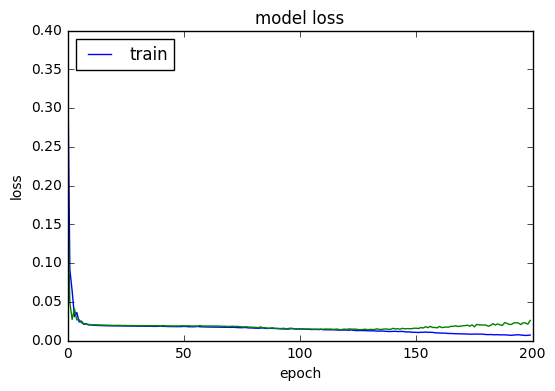

In [109]:
num_epochs = 200
loss_fuc = 'mean_squared_error'

# construct the callback
filepath="best_epoch.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(output_dim))
model.compile(loss=loss_fuc, optimizer='adam')
model.summary()
history_w_model = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=num_epochs, batch_size=64, validation_data=(x_test,y_test))

plt.plot(history_w_model.history['loss'], label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history_w_model.history['val_loss'], label='Val_loss')
plt.show()

In [66]:
# load weights into the model
model.load_weights("best_epoch.hdf5")
print("Loaded model from disk")

model.compile(loss='mean_squared_error', optimizer='adam')

Loaded model from disk


In [40]:
''' === Prediction ===
Procedure:
1. Load CSV
2. to_datetime
3. create timeofday column
4. change it to stationary
5. Use using_cols to select the features
6. del 'date'
7. change to np array
8. MinMaxScaler
9. make the sequences tensor as input
10. make a forloop for prediction

'''

# 1. Load CSV
df_pred = pd.read_csv('./create_input_array/phase1_testing_vol_route_weather_joined_table.csv')

# 2. to_datetime
df_pred['date'] = pd.to_datetime(df_pred['date'])

# 3. create timeofday column
df_pred['timeofday'] = df_pred.date.apply( lambda d : d.hour+d.minute/60.)

# 4. change it to stationary
df_pred_copy = df_pred.copy()

for i in range(1, len(df_pred_copy)):
    df_pred_copy.loc[i, df_pred_copy.columns[0:36]] = df_pred.loc[i, df_pred.columns[0:36]] - df_pred.loc[i-1, df_pred.columns[0:36]]

# 5. Use using_cols to select the features


sel_rows_test = sel_rows_test[ using_cols ]
sel_rows_test.shape

(84, 14)

In [36]:
del sel_rows_test['date']
# get numpy array from panda dataframe
test_phase1_arr = sel_rows_test.values


test_phase1_arr_w_station = difference(test_phase1_arr, 1)

# scale feature array to range -1 to 1
test_phase1_arr_scaled = scaler.transform(test_phase1_arr_w_station)

KeyError: 'date'

In [38]:
test_phase1_arr_scaled.shape

(82, 13)

In [39]:
len(test_phase1_arr_scaled)

82

In [ ]:
# Put into the model to get the prediction
te
for i in range(len(test_phase1_arr_scaled)):
    test_phase1_input = []
    test_phase1_input.append(test_phase1_arr_scaled[i:i+6])
    for t in range(6):
        model.predict(test_phase1_seqs)
    
    

In [33]:
# sample subsequence from the time series 
test_phase1_seqs = []
test_phase1_nSeg = test_phase1_arr_scaled.shape[0]//12 # each segment holds 4hr data (12 datapoints, 20min each)
for segment in range(test_phase1_nSeg):
    for t in range(6):
        startIdx = segment*12 + t
        test_phase1_seqs.append(test_phase1_arr_scaled[startIdx: startIdx+7])
test_phase1_seqs = np.stack(test_phase1_seqs)

In [35]:
test_phase1_seqs.shape

(36, 7, 13)

In [ ]:
pred_arr = []
for i in range(6):
    model.predict(test_phase1_seqs)
    